# Scrutinizing the Belle II anomaly with an ALP solution
In this notebook, corresponding to Section 6.3 of our work <a href="#AlpacaPheno">[0]</a>, we perform the analysis of the excess observed by the Belle II experiment in the $B^+\to K^+\nu\bar{\nu}$ at $2.8\,\sigma$ significance level <a href="#Belle-II2023esi">[1]</a>. Following <a href="#Altmannshofer2023hkn">[2]</a>, the Belle II result, together with the previous BaBar measurement <a href="#BaBar2013npw">[3]</a>, are interpreted as two-body decays $B^+\to K^+a$, where the ALP is experimentally reconstructed as missing energy. The most significant hint of an ALP is found at $m_a = 2\,\mathrm{GeV}$.

In [ ]:
import alpaca
from alpaca import ALPcouplings
import numpy as np
import matplotlib.pyplot as plt

from alpaca.statistics.chisquared import get_chi2
from alpaca.statistics.functions import nsigmas
from alpaca.plotting.mpl import exclusionplot
from alpaca.statistics import combine_chi2
from alpaca.experimental_data.measurements_exp import get_measurements
from alpaca.experimental_data.theoretical_predictions import get_th_uncert, get_th_value
# from alpaca.experimental_data.classes import decay_probability
from alpaca.sectors import default_sectors

plt.rcParams.update({'font.size': 20, 'text.usetex': True, 'font.family': 'serif', 'font.serif': 'Computer Modern Roman'})

## Fit Babar Belle II

As oppsed to <a href="#Altmannshofer2023hkn">[2]</a>, we do not (implicitly) assume that the ALP is infinitely long-lived. If we want to combine both experimental measurements, we must be aware of their different experimental settings: the produced ALP has a different boost in the LAB reference frame, and the characteristic length of the detector is also different. Therefore, we perform a fit to the two ALP properties that determine the invisible branching ratio $\mathrm{BR}(B^+\to K^+ \mathrm{inv})$, that is, $\mathrm{BR}(B^+ \to K^+ a)$ and the lifetime $\tau_a$.

In [23]:
ma=2.0
def combined_belle2_babar(ma: float, BR_BKinv: float, ctau: float):
    transition='B+->K+ alp'
    measurement_belle_2 = get_measurements(transition, exclude_projections=True)['Belle II']
    measurement_babar = get_measurements(transition, exclude_projections=True)['BaBar']
    
    values_belle_2=[measurement_belle_2.get_central(ma, ctau)[0],measurement_belle_2.get_sigma_left(ma, ctau)[0], measurement_belle_2.get_sigma_right(ma, ctau)[0]]
    values_babar=[measurement_babar.get_central(ma, ctau)[0], measurement_babar.get_sigma_left(ma, ctau)[0], measurement_babar.get_sigma_right(ma, ctau)[0]]

    pred_babar_all=BR_BKinv*measurement_babar.decay_probability(ctau, ma)
    pred_belle2_all=BR_BKinv*measurement_belle_2.decay_probability(ctau, ma)

    mask_low_babar  = (pred_babar_all <= values_babar[0])
    mask_high_babar = ~mask_low_babar

    mask_low_belle2  = (pred_belle2_all <= values_belle_2[0])
    mask_high_belle2 = ~mask_low_belle2
    
    chi2_babar_all  = np.empty_like(pred_babar_all)
    chi2_belle2_all = np.empty_like(pred_belle2_all)

    chi2_babar_all[mask_low_babar]  = ((pred_babar_all[mask_low_babar]  - values_babar[0])**2) / (values_babar[1]**2)
    chi2_babar_all[mask_high_babar] = ((pred_babar_all[mask_high_babar] - values_babar[0])**2) / (values_babar[2]**2)

    chi2_belle2_all[mask_low_belle2]  = ((pred_belle2_all[mask_low_belle2]  - values_belle_2[0])**2) / (values_belle_2[1]**2)
    chi2_belle2_all[mask_high_belle2] = ((pred_belle2_all[mask_high_belle2] - values_belle_2[0])**2) / (values_belle_2[2]**2)
    
    return chi2_babar_all + chi2_belle2_all, values_babar, values_belle_2
ctau_vals = np.logspace(1, 5, 5000)         # shape (200,)
BR_vals   = np.logspace(-6, -2, 5000)       # shape (200,)
X_grid, Y_grid = np.meshgrid(ctau_vals, BR_vals) 
chi2_total, values_babar, values_belle_2 = combined_belle2_babar(ma, Y_grid, X_grid)  # shape (200,

(1e-06, 0.01)

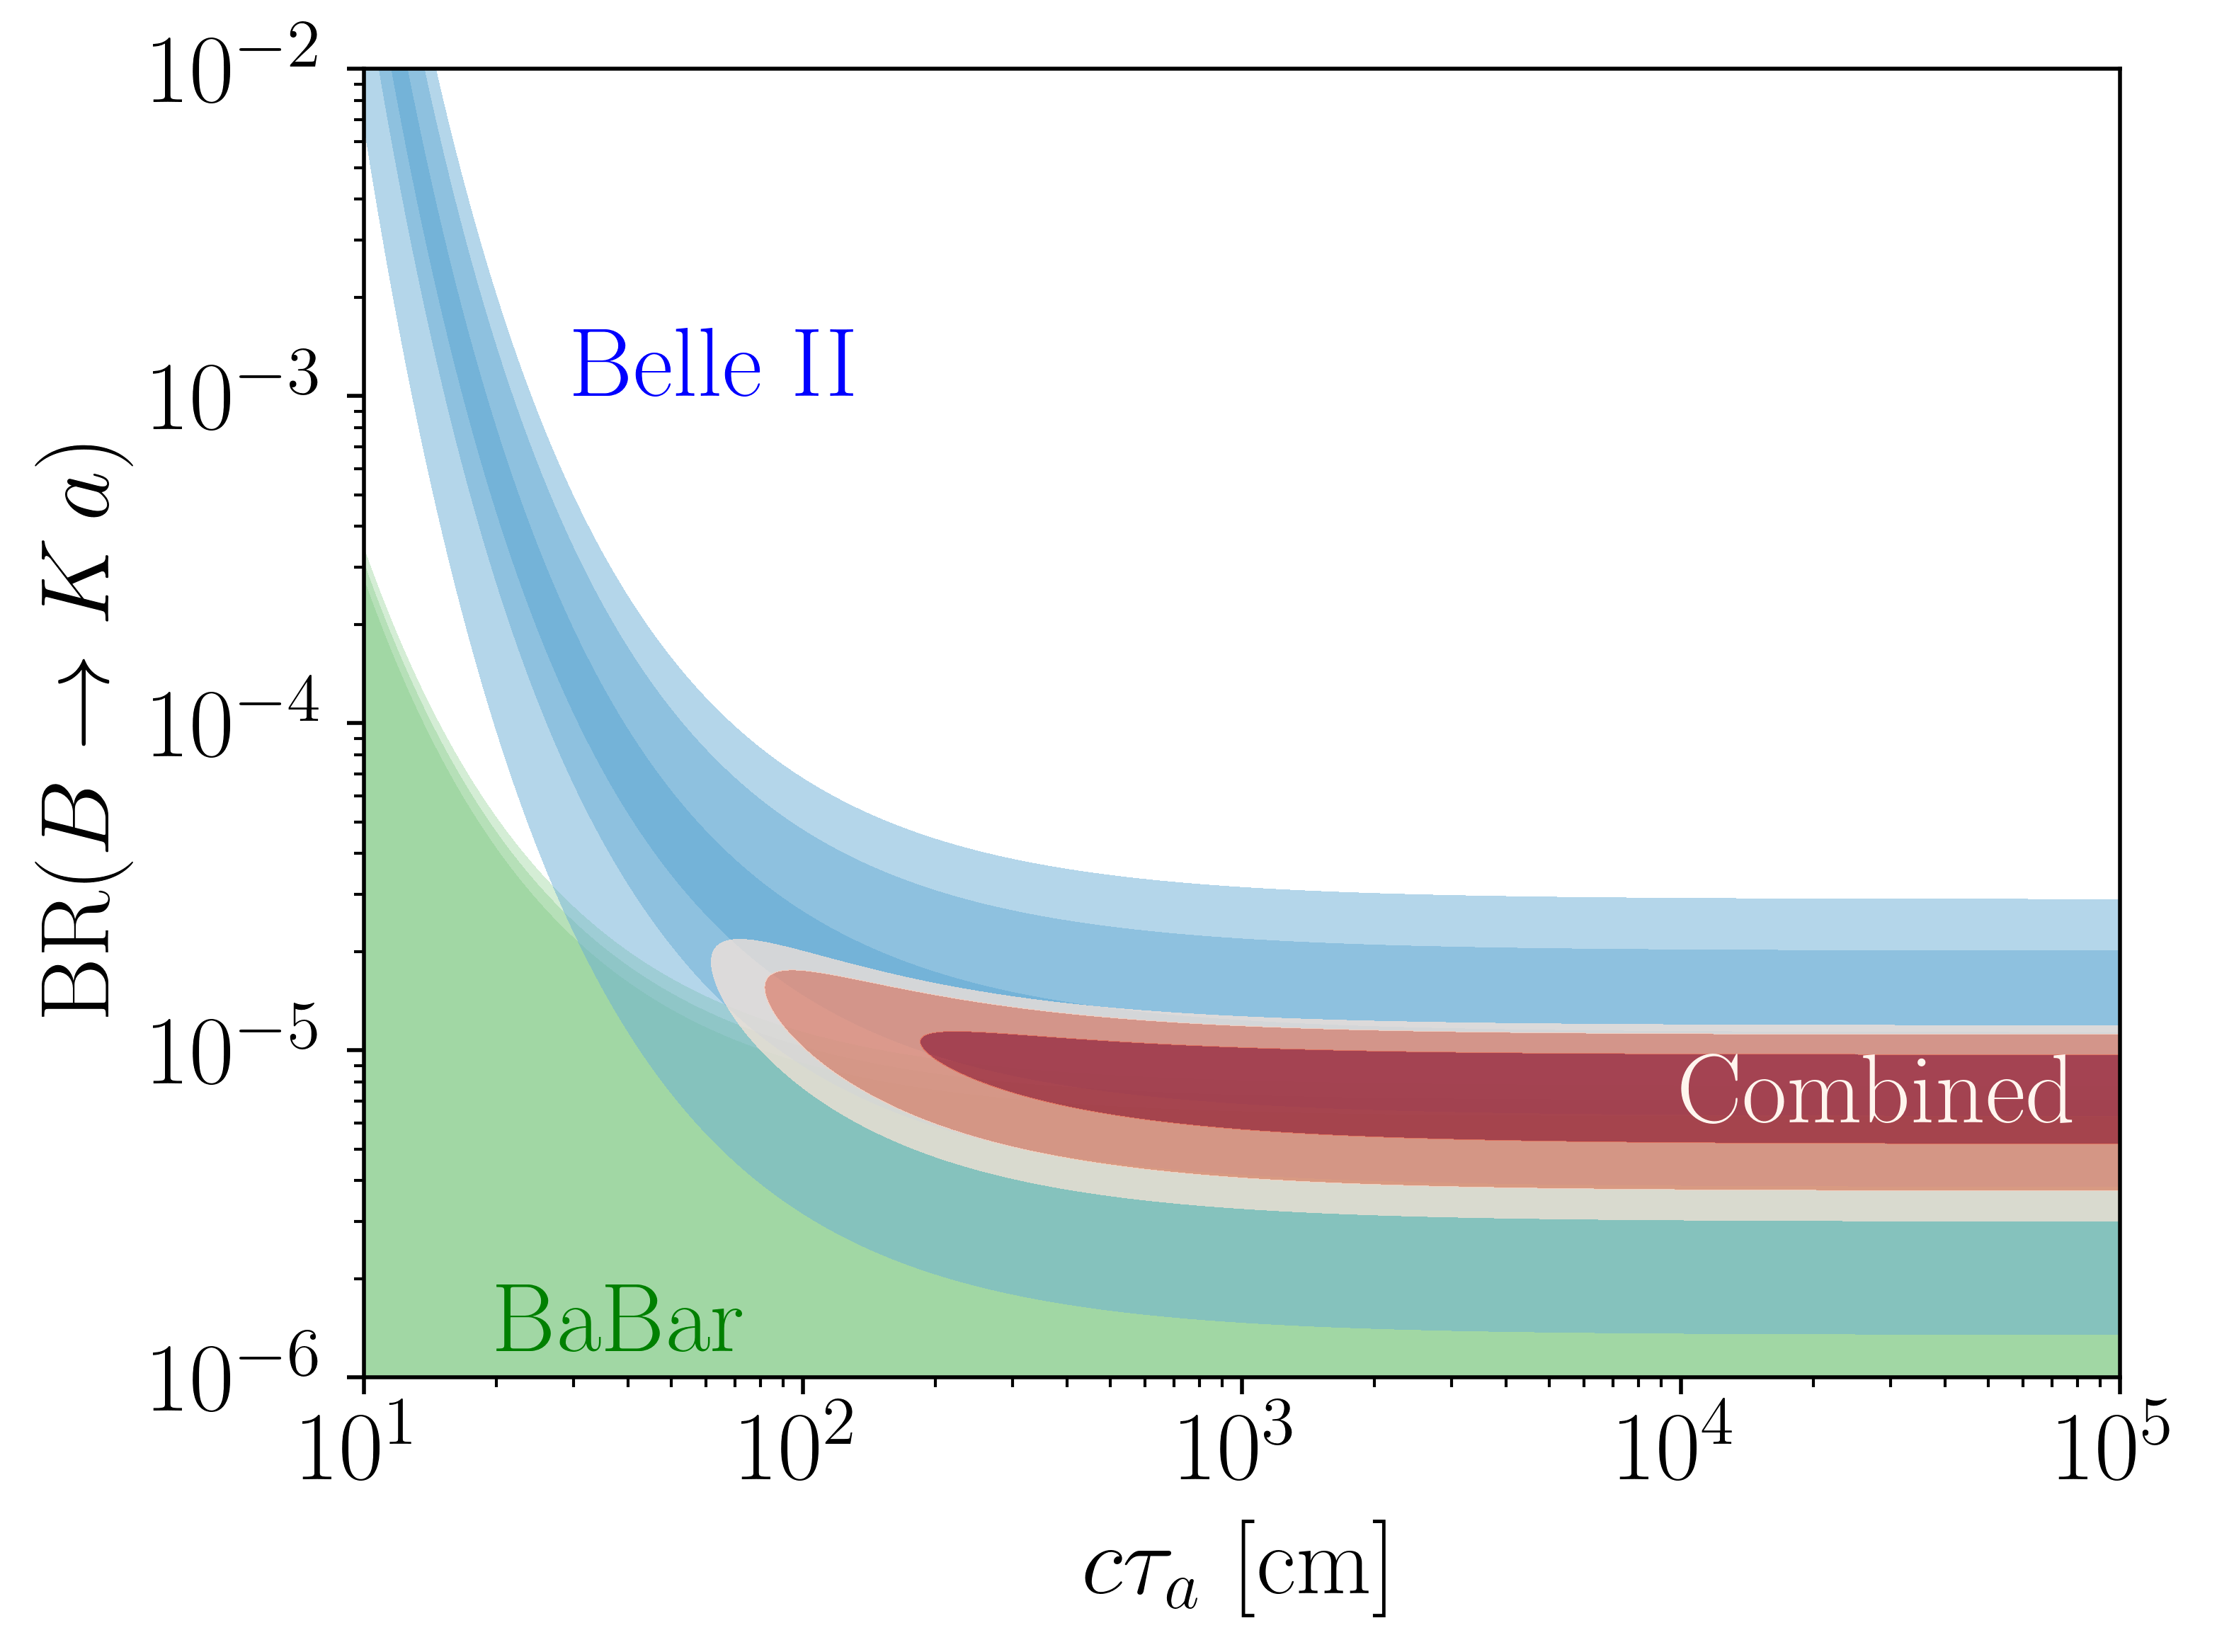

In [24]:
from matplotlib.colors import LogNorm

ctau_vals = np.logspace(1, 5, 5000)         # shape (200,)
BR_vals   = np.logspace(-6, -2, 5000)       # shape (200,)
X_grid, Y_grid = np.meshgrid(ctau_vals, BR_vals) 
chi2_total, values_babar, values_belle_2 = combined_belle2_babar(ma, Y_grid, X_grid)  # shape (200, 200)

transition='B+->K+ a'
measurement_belle_2 = get_measurements(transition, exclude_projections=True)['Belle II']
measurement_babar = get_measurements(transition, exclude_projections=True)['BaBar']

fig, ax = plt.subplots(dpi=500)
babarZ=Y_grid*measurement_babar.decay_probability(X_grid, ma)
belle2Z=Y_grid*measurement_belle_2.decay_probability(X_grid, ma)
ax.contourf(X_grid, Y_grid, babarZ, levels=[values_babar[0]-values_babar[1], values_babar[0]+values_babar[2]], cmap='Greens', alpha=0.3)
ax.contourf(X_grid, Y_grid, babarZ, levels=[values_babar[0]-2*values_babar[1], 2*values_babar[0]+values_babar[2]], cmap='Greens', alpha=0.3)
ax.contourf(X_grid, Y_grid, babarZ, levels=[values_babar[0]-3*values_babar[1], 3*values_babar[0]+values_babar[2]], cmap='Greens', alpha=0.3)

ax.contourf(X_grid, Y_grid, belle2Z, levels=[values_belle_2[0]-values_belle_2[1], values_belle_2[0]+values_belle_2[2]], cmap='Blues', alpha=0.7)
ax.contourf(X_grid, Y_grid, belle2Z, levels=[values_belle_2[0]-2*values_belle_2[1], 2*values_belle_2[0]+values_belle_2[2]], cmap='Blues', alpha=0.5)
ax.contourf(X_grid, Y_grid, belle2Z, levels=[values_belle_2[0]-3*values_belle_2[1], 3*values_belle_2[0]+values_belle_2[2]], cmap='Blues', alpha=0.5)



cs=ax.contourf(X_grid, Y_grid, chi2_total, levels=[np.min(chi2_total), np.min(chi2_total)+1,np.min(chi2_total)+2.7,np.min(chi2_total)+3.84], norm=LogNorm(), cmap='Reds_r', alpha=0.7)

ax.text(3*1e1, 1e-3, r'Belle II',  color='blue')
ax.text(2*1e1, 1.2e-6, r'BaBar',  color='green')
ax.text(1*1e4, 0.6e-5, r'Combined',  color='seashell')
ax.set_xlabel(r'$c\tau_a$ [cm]')
ax.set_ylabel(r'$\mathrm{BR}(B \to K \, a)$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(10, 1e5)
ax.set_ylim(1e-6, 1e-2)
#fig.savefig('fit_pinv_BR.pdf', bbox_inches='tight')

## Parameters at low energy

We perform a two-coefficient analysis in the framework of the low-energy ALP-EFT of the coefficients that are more relevant for the $B^+\to K^+\mathrm{inv}$ decays: the flavour-violating coefficient $c_{sb}^V$ responsible for the $B^+\to K^+a$ decay, and $c_G$ and $c_{\mu\mu}^A$, responsible main decay channels (hadronic and muonic) that dominate the ALP lifetime.

In [2]:
ma = 2
fa_cG = 1e5

cgamma_vec = np.logspace(-3,0 , 50)
cbsV_vec= np.logspace(-4, -2, 50)

cbsV_grid, cgamma_grid = np.meshgrid(cbsV_vec, cgamma_vec)

ccgamma_flat = cgamma_grid.flatten()
cbsV_flat = cbsV_grid.flatten()


couplings_list = []
for ccgamma_val, cbsV_val in zip(ccgamma_flat, cbsV_flat):
    coupling = ALPcouplings({'cG': ccgamma_val, 'cdV': np.array([[0,0,0],[0,0,cbsV_val],[0,cbsV_val,0]])}, scale=5.1, basis='VA_below')
    couplings_list.append(coupling)

couplings_cgamma = np.array(couplings_list).reshape(cgamma_grid.shape)

fa_grid = np.full(cgamma_grid.shape, fa_cG)
ma_grid = np.full(cgamma_grid.shape, ma)

In [4]:
chi2_cgamma = get_chi2(default_sectors['bsa_lfu'], ma_grid, couplings_cgamma, fa_grid, integrator='no_rge', min_probability=0)
chi2_cgamma_meas=chi2_cgamma[0].split_measurements()

In [5]:
ma = 2
fa = 1e7

cmu_vec = np.logspace(-3,-1 , 50)
cbsV_vec= np.logspace(-2, 0, 50)

cbsV_grid_mu, cmu_grid = np.meshgrid(cbsV_vec, cmu_vec)

ccmu_flat = cmu_grid.flatten()
cbsV_flat = cbsV_grid_mu.flatten()

couplings_list = []
for ccmu_val, cbsV_val in zip(ccmu_flat, cbsV_flat):
    coupling = ALPcouplings({'ceA': np.diag([0,ccmu_val,0]), 'cdV': np.array([[0,0,0],[0,0,cbsV_val],[0,cbsV_val,0]])}, scale=5.1, basis='VA_below')
    couplings_list.append(coupling)

couplings_cmuons= np.array(couplings_list).reshape(cmu_grid.shape)

fa_grid = np.full(cmu_grid.shape, fa)
ma_grid = np.full(cmu_grid.shape, ma)

In [6]:
chi2_cmuons= get_chi2(default_sectors['bsa_lfu'], ma_grid, couplings_cmuons, fa_grid, integrator='no_rge', min_probability=0)
chi2_cmuons_meas=chi2_cmuons[0].split_measurements()


In [9]:
for c in chi2_cmuons_meas:
    if c.sector.name == 'B+ -> K+ muon muon @ CHARM':
        c.set_plot_style(color="#d62728",lw=5)
    if c.sector.name == 'B+ -> K+ muon muon @ LHCb':
        c.set_plot_style(color="#9bb333",lw=5)
    if c.sector.name == 'B0 -> K0 alp @ Belle':
        c.set_plot_style(color="#821e99",lw=5)
        c.sector.tex = r'$B^0 \to K^0 \nu \bar{\nu}\ \mathrm{(Belle)}$'
    if c.sector.name == 'B+ -> K+ alp @ BaBar':
        c.set_plot_style(color="#3650c4",lw=5)
        c.sector.tex = r'$B^+ \to K^+ \nu \bar{\nu}\ \mathrm{(BaBar)}$'
    elif c.sector.name == 'B+ -> K+ alp @ Belle II':
        c.set_plot_style(color="#0D5B11",lw=5)
        c.sector.tex = r'$B^+ \to K^+ \nu \bar{\nu}\ \mathrm{(Belle\ II)}$'
    else:
        c.set_plot_style(lw=5)
    
for c in chi2_cgamma_meas:
    if c.sector.name == 'B0 -> K0 alp @ Belle':
        c.set_plot_style(color="#821e99",lw=5)
        c.sector.tex = r'$B^0 \to K^0 \nu \bar{\nu}\ \mathrm{(Belle)}$'
    if c.sector.name == 'B+ -> K+ alp @ BaBar':
        c.set_plot_style(color="#3650c4",lw=5)
        c.sector.tex = r'$B^+ \to K^+ \nu \bar{\nu}\ \mathrm{(BaBar)}$'
    elif c.sector.name == 'B+ -> K+ alp @ Belle II':
        c.set_plot_style(color="#0D5B11",lw=5)
        c.sector.tex = r'$B^+ \to K^+ \nu \bar{\nu}\ \mathrm{(Belle\ II)}$'
    else:
        c.set_plot_style(lw=5)



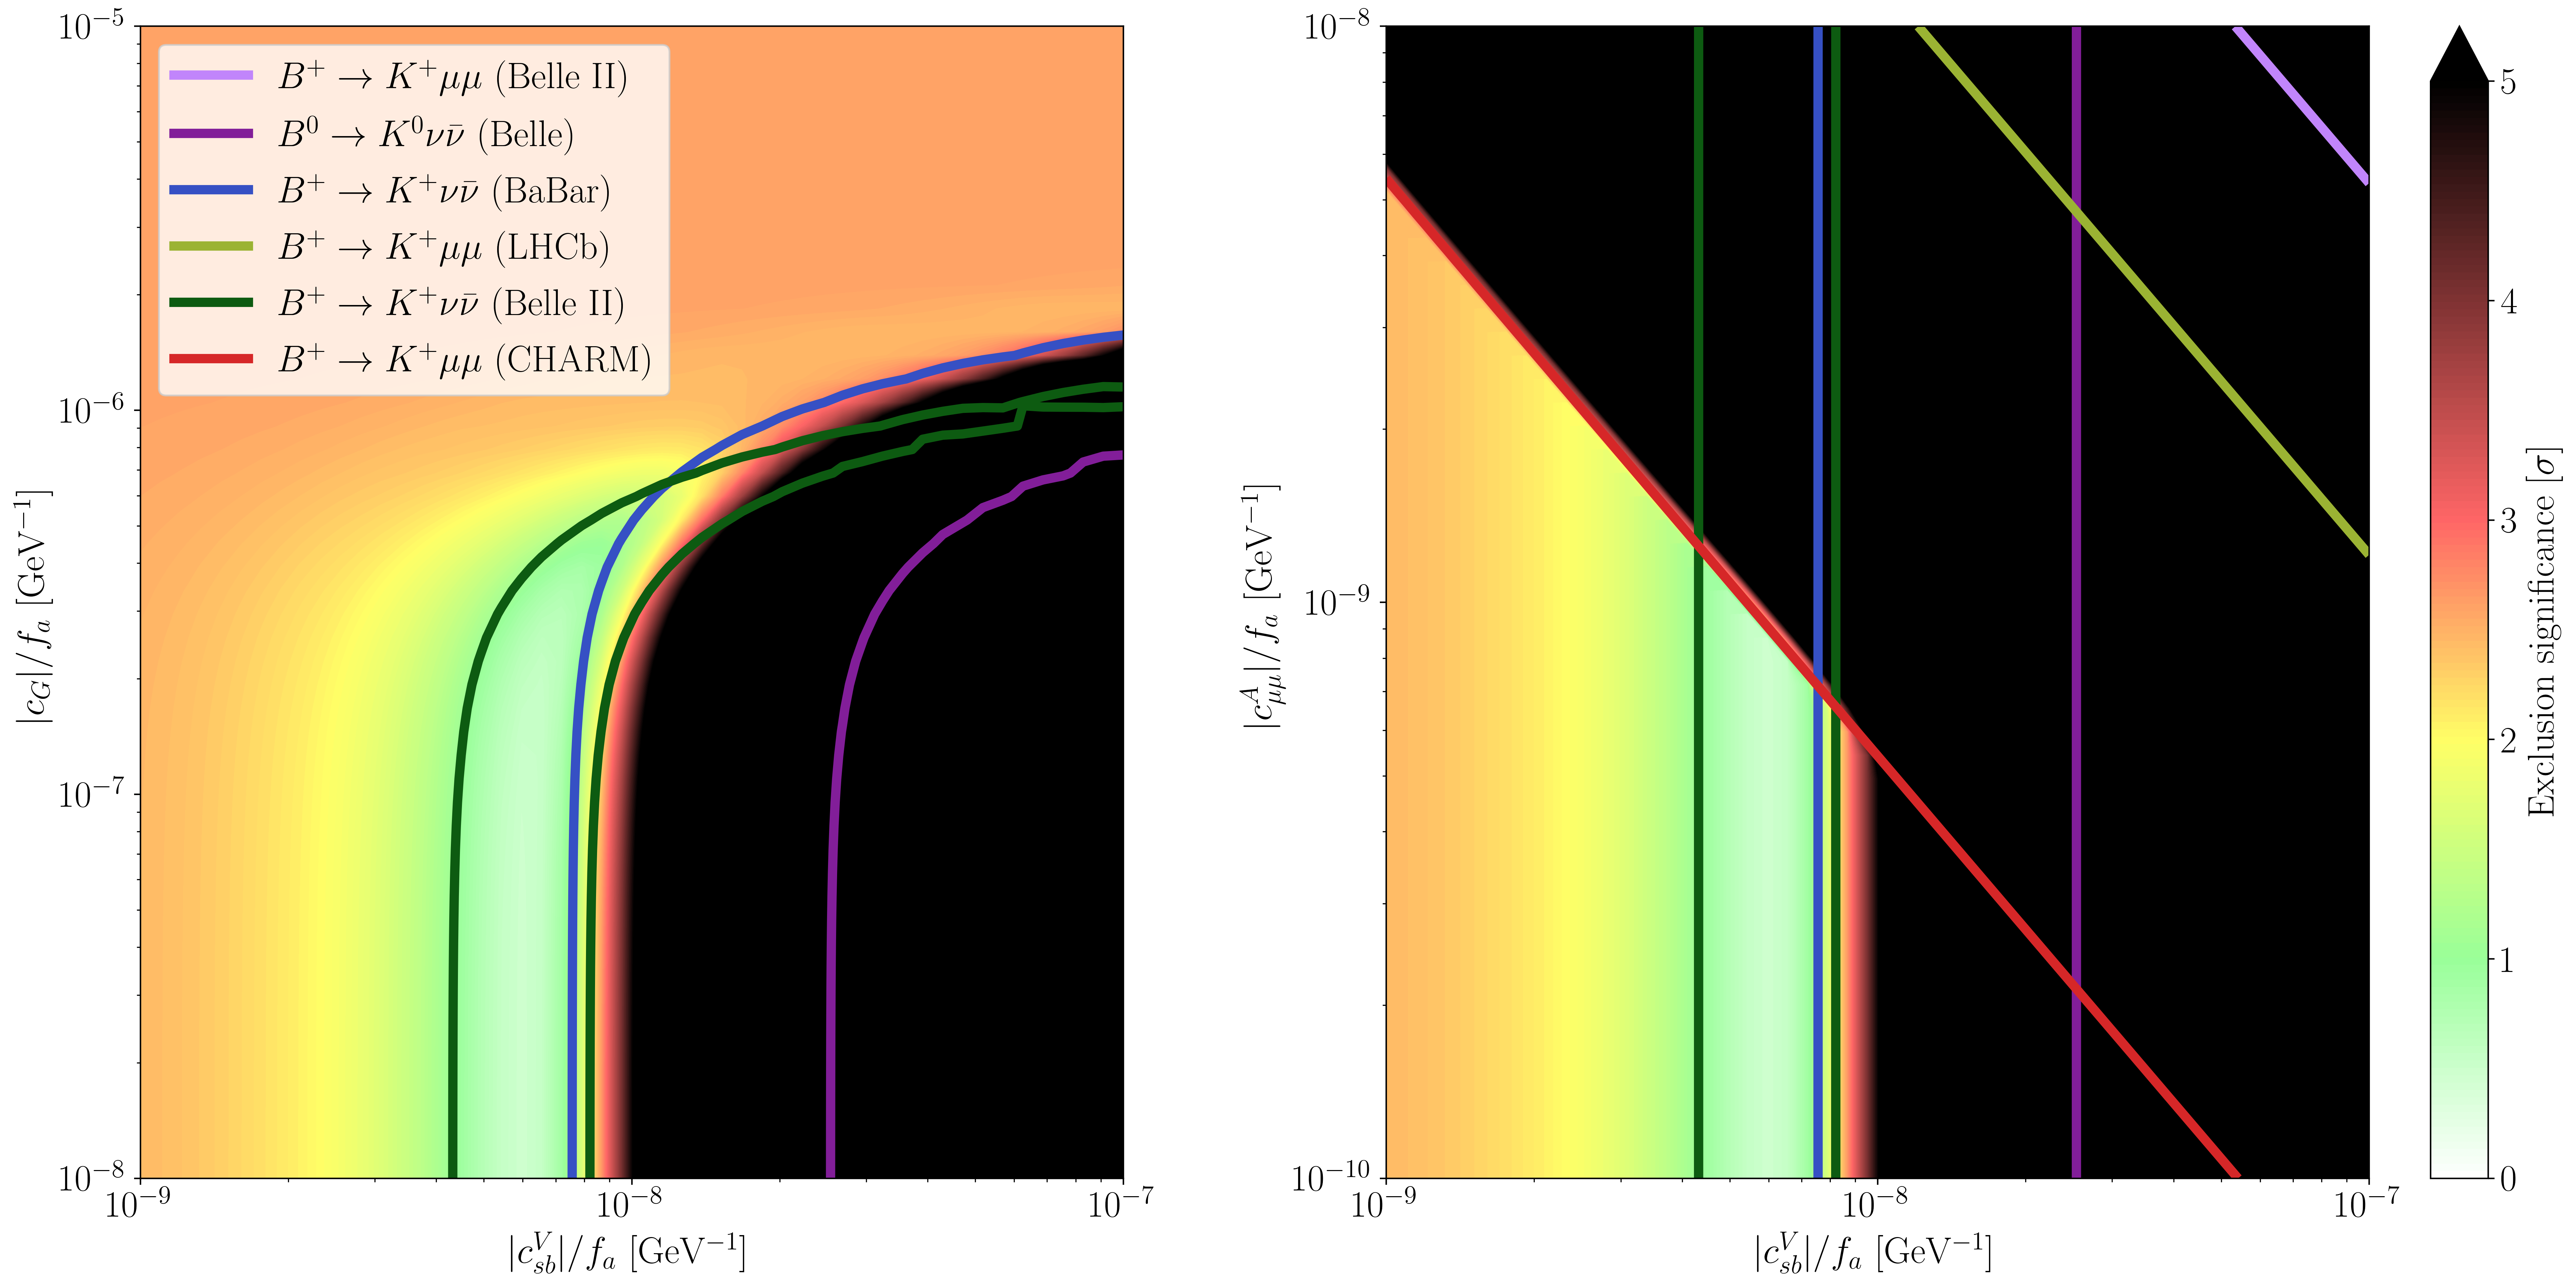

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=400)

ax1=exclusionplot(cbsV_grid/fa_cG, cgamma_grid/fa_cG, chi2_cgamma_meas, r'$|c_{sb}^V|/f_a$ [GeV$^{-1}$]', r'$|c_{G}|/f_a$ [GeV$^{-1}$]', ax=axs[0])
ax2=exclusionplot(cbsV_grid_mu/fa, cmu_grid/fa, chi2_cmuons_meas, r'$|c_{sb}^V|/f_a$ [GeV$^{-1}$]', r'$|c_{\mu\mu}^A|/f_a$ [GeV$^{-1}$]', ax=axs[1])


# ax1.get_legend().remove()
ax1.get_legend().remove()
leyenda = ax2.get_legend()

handles, labels = leyenda.legend_handles, [t.get_text() for t in leyenda.texts]
ax1.legend(handles, labels, loc=2)
ax2.get_legend().remove()
fig.axes[2].set_visible(False)
fig.tight_layout()
#fig.savefig('ALP_BK_muons_gluons.pdf', bbox_inches='tight')

## Non-universal DFSZ model

Finally, we propose a non-universal model (see <a href="#AlpacaPheno">[0]</a> for more details) that is capable of describing the current experimental excess while evading the bounds from $B^+\to K^+\mu^mu^-$.

In [12]:
ma = 2

tanb = np.logspace(np.log10(0.2), 2, 100)
fa_vec= np.logspace(6, 8, 100)

fa_grid, tanb_grid = np.meshgrid(fa_vec, tanb)


fa_flat = fa_grid.flatten()
tanb_flat = tanb_grid.flatten()

couplings_list = []
for fa_val, tanb_val in zip(fa_flat, tanb_flat):
    sinb2= tanb_val**2/(1+tanb_val**2)
    cosb2= 1-sinb2
    coupling = alpaca.ALPcouplings({'cG': -1/2, 'cW': 2, 'cB': -10/3, 'cdR': cosb2, 'cuR': sinb2, 'ceR': cosb2, 'cqL': np.diag([0,0,1]), 'clL': np.diag([0,0,1])}, scale=fa_val, basis='derivative_above').match_run(ma, 'VA_below', 'leadinglog')
    couplings_list.append(coupling)

couplings_2HDM1 = np.array(couplings_list).reshape(fa_grid.shape)

ma_grid = np.full(fa_grid.shape, ma)

In [13]:
chi2_2HDM1 = alpaca.statistics.get_chi2(alpaca.sectors.default_sectors['bsa_lfu'],
ma_grid, couplings_2HDM1, fa_grid, integrator='no_rge', min_probability=0)


In [14]:
chi2_2HDM1_proj = alpaca.statistics.get_chi2(alpaca.sectors.default_sectors['bsa_lfu'],
ma_grid, couplings_2HDM1, fa_grid, integrator='no_rge', min_probability=0, exclude_projections=False)

In [15]:
chi2_obs = chi2_2HDM1[0].split_observables()
chi2_meas = chi2_2HDM1_proj[0].split_measurements()
chi2_ship = [c for c in chi2_meas if 'SHiP' in c.sector.name]

In [16]:
for c in chi2_obs:
    c.set_plot_style(lw=2.5)
    if c.sector.name == 'B+ -> K+ alp':
        c.set_plot_style(color="#09d6fa", lw=2.5)
    elif c.sector.name == 'B+ -> K*+ alp':
        c.set_plot_style(color="#c767e7", lw=2.5)
        print(c.split_measurements())
    elif c.sector.name == 'B+ -> K+ muon muon':
        c.set_plot_style(color="#27d650", lw=2.5)
for c in chi2_ship:
    c.set_plot_style(color="#747474", ls='--')

0:	B+ -> K*+ alp @ BaBar


In [17]:
chi2_obs_ord = [c for c in chi2_obs if c.sector.contains_observable('B+ -> K+ a')] + [c for c in chi2_obs if c.sector.contains_observable('B+ -> K*+ a')] + [c for c in chi2_obs if c.sector.contains_observable('B+ -> K+ mu mu')] + chi2_ship

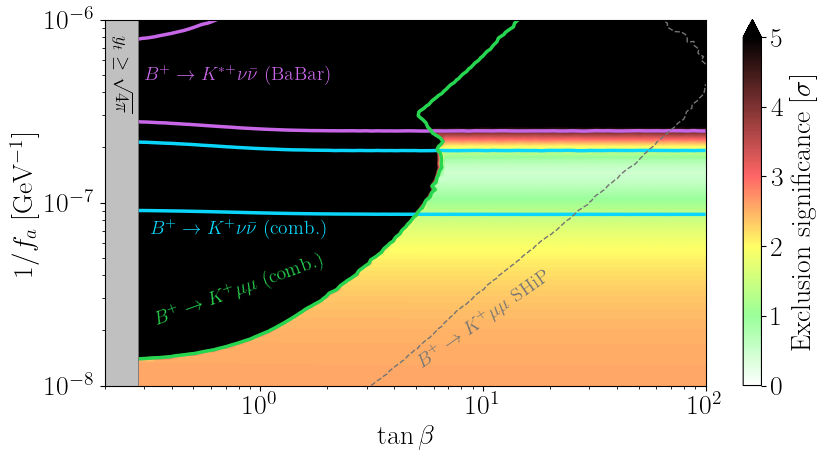

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
ax = exclusionplot( tanb_grid, 1/fa_grid,chi2_obs_ord, r'$\tan\beta$', r'$1/f_a$ [GeV$^{-1}$]',global_chi2=chi2_2HDM1[0], ax=ax)
# ax = exclusionplot( tanb_grid, fa_grid,chi2_meas[11], r'$\tan\beta$', r'$f_a$ [GeV]',global_chi2=chi2_2HDM1[0], ax=ax)

# ax.get_legend().set_bbox_to_anchor((0.55, 0.35, 1.0, 1.0))
ax.get_legend().remove()


ax.vlines(0.28, 1e-6, 1e-8, color='dimgray', linewidth=2)
ax.fill_betweenx([ 1e-6, 1e-8],0.1, 0.28, color='silver', alpha=1, label=r'$y_t\leq \sqrt{4\pi}$',zorder=2)
ax.text(0.24, 1/2e6, r'$y_t\geq \sqrt{4\pi} $', fontsize=14, color='black', ha='center', va='center', rotation=-90)
ax.text(0.8, 1/1.4e7, r'$B^+\to K^+ \nu\bar{\nu}$ (comb.)', fontsize=14, color='#09d6fa', ha='center', va='center', rotation=0)
ax.text(0.8, 1/2e6, r'$B^+\to K^{*+} \nu\bar{\nu}$ (BaBar)', fontsize=14, color='#c767e7', ha='center', va='center', rotation=0)
ax.text(0.8, 1/3e7, r'$B^+\to K^+ \mu\mu$ (comb.)', fontsize=14, color='#27d650', ha='center', va='center', rotation=20)
ax.text(10, 1/4.3e7, r'$B^+\to K^+ \mu\mu$ SHiP', fontsize=14, color='#747474', ha='center', va='center', rotation=35)
ax.set_xlim(0.2, 100)
ax.set_ylim(1e-8, 1e-6)
#fig.savefig('non_un_2HDM_2.pdf', bbox_inches='tight')


## References



<a id="AlpacaPheno">[0]</a>    
J. Alda, M. Fuentes Zamoro, L. Merlo, X. Ponce Diaz, S. Rigolin    
*Comprehensive ALP searches in Meson Decays*,    
In preparation.

<a id="Belle-II2023esi">[1]</a>    
I. Adachi *et al.* [Belle-II],    
*Evidence for $B^+\to K^+\nu \bar{\nu}$ decays*,    
[Phys. Rev. D **109** (2024) no.11, 112006](https://dx.doi.org/10.1103/PhysRevD.109.112006)    
[arXiv:2311.14647 [hep-ex]](https://arxiv.org/abs/2311.14647).

<a id="Altmannshofer2023hkn">[2]</a>    
W. Altmannshofer, A. Crivellin, H. Haigh, G. Inguglia and J. Martin Camalich,    
*Light new physics in $B\to K^{(*)}\nu\bar{\nu}$?*,    
[Phys. Rev. D **109** (2024) no.7, 075008](https://dx.doi.org/10.1103/PhysRevD.109.075008)    
[arXiv:2311.14629 [hep-ph]](https://arxiv.org/abs/2311.14629).

<a id="BaBar2013npw">[3]</a>    
J. P. Lees *et al.* [BaBar],    
*Search for $B \to K^{(*)} \nu \overline \nu$ and invisible quarkonium decays*,    
[Phys. Rev. D **87** (2013) no.11, 112005](https://dx.doi.org/10.1103/PhysRevD.87.112005)    
[arXiv:1303.7465 [hep-ex]](https://arxiv.org/abs/1303.7465).